In [4]:
import geopandas as gpd

COMPLETE_DATA_FILE = (
    "/workspaces/sailbot_workspace/src/local_pathfinding/land/shp/complete_land_data.shp"
)

gdf = gpd.read_file(COMPLETE_DATA_FILE)

In [ ]:
gdf.explore()

In [14]:
# what one coordniate in one polygon in latlon polygons will look like
gdf["geometry"][0].exterior.coords[0]

(-109.69244914237343, 27.054225788424148)

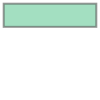

In [9]:
from shapely.geometry import box, Point, MultiPolygon

box1 = box(0, 0, 1, 1)
box2 = box(1, 0, 4, 1)

bbox = box(*MultiPolygon([box1, box2]).bounds)
bbox

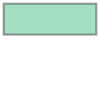

In [6]:
box2

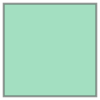

In [7]:
box1

In [43]:
from local_pathfinding.land_polygon_etl import load_pkl
from local_pathfinding.obstacles import Land
from custom_interfaces.msg import HelperLatLon
from shapely.geometry import Point, box, MultiPolygon

reference_point = HelperLatLon(latitude=48.927646856442834, longitude=-125.18555198866946)
sailbot_position = HelperLatLon(latitude=48.842045056421135, longitude=-125.29181185529734)
next_waypoint = HelperLatLon(latitude=48.92893492027311, longitude=-125.37140872956104)
sindex = load_pkl("/workspaces/sailbot_workspace/src/local_pathfinding/land/pkl/sindex.pkl")
bbox_buffer_amount = 0.1

# create a box around sailbot
sailbot_box = Point(sailbot_position.longitude, sailbot_position.latitude).buffer(
    bbox_buffer_amount, cap_style="square", join_style=2
)
# create a box around the next waypoint
waypoint_box = Point(next_waypoint.longitude, next_waypoint.latitude).buffer(
    bbox_buffer_amount, cap_style="square", join_style=2
)
# create a bounding box around both boxes
bbox = box(*MultiPolygon([sailbot_box, waypoint_box]).bounds)

row_ids = list(sindex.query(geometry=bbox, predicate="intersects"))
len(row_ids)
for row in row_ids:
    print(row)

2144
2146
2148
2150
2149
2151
2152
2153
2155
2154
2156
2157
2158
2159
2161
2163
2165
2166
2168
2169
2170
2171
2175
2176
2178
2179
2180
2035
2181
2182
2184
2183
2185
2186
2187
2189
2190
2191
2192
2193
2194
2196
2195
2198
1938
2200
2201
1939
1940
1870
1942
2038
2036
2037
1943
1944
2039
1945
1946
2040
2041
2042
1948
1947
1950
1949
1951
1952
2043
1953
2167
1954
2044
2045
1956
1844
1955
1957
1958
1959
2046
2048
2047
1960
1961
2049
1962
2050
1963
1964
2052
2053
2054
1966
2055
1965
1967
1968
1846
1969
1970
1971
1972
1973
2056
1974
1975
2057
1976
1977
1978
1979
1980
1981
2058
1982
1983
2059
1984
2060
1985
1987
1986
1849
1850
1988
1825
1989
1990
2062
1991
2061
1811
1992
1840
1993
2063
1994
2064
1842
1845
1852
1853
1856
1857
2065
2066
1995
1996
1855
2067
2068
1862
2069
2070
1860
1858
1859
1861
1863
1865
1864
1866
1867
1871
2071
2072
1877
2073
2074
1879
2075
1997
2076
2077
1868
1869
1872
1874
1873
1875
1876
1878
1880
1883
1998
1881
2078
2079
1882
1999
2000
2001
2002
2003
2004
2005
2006
2008
2009


In [51]:
from geopandas import GeoDataFrame
import fiona

"""with fiona.open(
    "/workspaces/sailbot_workspace/src/local_pathfinding/land/shp/complete_land_data.shp", "r"
) as reader:

    latlon_polygons = []
    for idx in row_ids:
        latlon_polygons.append(reader.get(idx)["geometry"])
        """
polygon_df = None
with fiona.open(
    "/workspaces/sailbot_workspace/src/local_pathfinding/land/shp/complete_land_data.shp", "r"
) as reader:
    polygon_df = GeoDataFrame(geometry=[reader.get(idx)["geometry"] for idx in row_ids])

In [52]:
polygon_df.explore()

In [53]:
polygon_df["geometry"]

0      POLYGON ((-125.19773 48.77061, -125.19924 48.7...
1      POLYGON ((-125.20106 48.77066, -125.20295 48.7...
2      POLYGON ((-125.20239 48.77255, -125.20619 48.7...
3      POLYGON ((-125.20932 48.77709, -125.20665 48.7...
4      POLYGON ((-125.20952 48.77665, -125.20774 48.7...
                             ...                        
501    POLYGON ((-125.31521 49.02615, -125.31804 49.0...
502    POLYGON ((-125.32593 49.02681, -125.32627 49.0...
503    POLYGON ((-125.3247 49.02833, -125.32611 49.02...
504    POLYGON ((-125.2298 49.02979, -125.23295 49.03...
505    POLYGON ((-126.56745 49.52534, -126.56745 49.5...
Name: geometry, Length: 506, dtype: geometry

In [1]:
import plotly.graph_objects as go
from numpy import ndarray
from custom_interfaces.msg import (
    HelperAISShip,
    HelperDimension,
    HelperHeading,
    HelperLatLon,
    HelperROT,
    HelperSpeed,
)
from local_pathfinding.coord_systems import XY, latlon_to_xy, meters_to_km
from local_pathfinding.obstacles import BOAT_BUFFER, Boat, Land, Obstacle
import numpy as np
from shapely.geometry import Point

# Sample AIS SHIP message
ais_ship = HelperAISShip(
    id=1,
    lat_lon=HelperLatLon(latitude=51.97917631092298, longitude=-137.1106454702385),
    cog=HelperHeading(heading=0.0),
    sog=HelperSpeed(speed=18.52),
    width=HelperDimension(dimension=20.0),
    length=HelperDimension(dimension=100.0),
    rot=HelperROT(rot=0),
)

# Create a boat object
boat1 = Boat(
    HelperLatLon(latitude=52.268119490007756, longitude=-136.9133983613776),
    HelperLatLon(latitude=51.95785651405779, longitude=-136.26282894969611),
    30.0,
    ais_ship,
)

# Choose some states for visual inspection
valid_state = HelperLatLon(latitude=50.42973337261916, longitude=-134.12018940923838)
invalid_state = HelperLatLon(latitude=52.174842845359755, longitude=-137.10372451905042)

# Extract coordinates for sailbot
sailbot_x, sailbot_y = boat1.sailbot_position
sailbot = go.Scatter(x=[sailbot_x], y=[sailbot_y], mode="markers", name="Sailbot Position")

fig1 = go.Figure(sailbot)

# Extract coordinates for valid and invalid states
valid_state_x, valid_state_y = latlon_to_xy(boat1.reference, valid_state)
valid_state = go.Scatter(x=[valid_state_x], y=[valid_state_y], mode="markers", name="Valid State")

fig1.add_trace(valid_state)

invalid_state_x, invalid_state_y = latlon_to_xy(boat1.reference, invalid_state)
invalid_state = go.Scatter(
    x=[invalid_state_x], y=[invalid_state_y], mode="markers", name="Invalid State"
)

fig1.add_trace(invalid_state)

# Extract exterior coordinates for boat1's collision cone
if boat1.collision_zone is not None:
    boat_x, boat_y = np.array(boat1.collision_zone.exterior.coords.xy)
    boat_x = np.array(boat_x)
    boat_y = np.array(boat_y)
    boat = go.Scatter(x=boat_x, y=boat_y, fill="toself", name="Boat Collision Cone")
    fig1.add_trace(boat)

# Manually calculate the length of the collision zone based on:
# - the boat's projected distance
# - the boat's length
# - the safety buffer
collision_zone_length = round(
    (
        boat1._calculate_projected_distance()
        + 2 * BOAT_BUFFER
        + meters_to_km(boat1.ais_ship.length.dimension)
    ),
    4,
)

fig1.add_annotation(
    text="Calculated Length of Collision Zone : " + str(collision_zone_length) + " km",
    align="center",
    showarrow=False,
    xref="paper",
    yref="paper",
    x=1,
    y=1,
    bordercolor="black",
    borderwidth=1,
)

# Measure the length of the collision zone based on the points of the polygon
x: ndarray
y: ndarray

if boat1.collision_zone is not None:
    x, y = boat1.collision_zone.exterior.coords.xy

mid_1 = Point((x[1] + x[2]) / 2, (y[1] + y[2]) / 2)
mid_2 = Point((x[0] + x[3]) / 2, (y[0] + y[3]) / 2)

length = round(mid_1.distance(mid_2), 4)

fig1.add_annotation(
    text="Measured Length of Collision Zone : " + str(length) + " km",
    align="center",
    showarrow=False,
    xref="paper",
    yref="paper",
    x=0.7,
    y=1,
    bordercolor="black",
    borderwidth=1,
)

fig1.update_layout(yaxis_range=[-200, 200], xaxis_range=[-200, 750])
fig1.show()

NameError: name 'Point' is not defined